# Lemniscate Snapshot Utilities Demo

This notebook builds a lemniscate (∞) factor graph, runs a single PropFlow engine execution with snapshots enabled, and exercises the snapshot utilities and visualisation helpers end-to-end.

In [1]:
from __future__ import annotations

from pathlib import Path
import json

import matplotlib.pyplot as plt
import numpy as np

from propflow import SnapshotAnalyzer, AnalysisReport, SnapshotVisualizer
from propflow.bp.engine_base import BPEngine
from propflow.configs import create_random_int_table
from propflow.snapshots.types import SnapshotsConfig
from propflow.snapshots.utils import (
    latest_snapshot,
    latest_jacobians,
    latest_cycles,
    latest_winners,
    get_snapshot,
)
from propflow.utils.fg_utils import FGBuilder

In [2]:
np.random.seed(7)

RUN_DIR = Path("results/notebooks/lemniscate_all_utils")
RUN_DIR.mkdir(parents=True, exist_ok=True)

snapshot_cfg = SnapshotsConfig(
    compute_jacobians=True,
    compute_block_norms=True,
    compute_cycles=True,
    include_detailed_cycles=True,
    compute_numeric_cycle_gain=False,
    retain_last=None,
    save_each_step=False,
)

graph = FGBuilder.build_lemniscate_graph(
    num_vars=8,
    domain_size=3,
    ct_factory=create_random_int_table,
    ct_params={"low": 1, "high": 7},
)

engine = BPEngine(
    factor_graph=graph,
    snapshots_config=snapshot_cfg,
    use_bct_history=True,
)


In [3]:
MAX_STEPS = 10
engine.run(max_iter=MAX_STEPS)

snapshots = list(engine.snapshots)
captured_steps = [rec.data.step for rec in snapshots]
print(f"Captured {len(captured_steps)} steps; final step = {captured_steps[-1]}")


Captured 10 steps; final step = 9


In [ ]:
latest = latest_snapshot(engine)
print("Latest snapshot step:", latest.data.step)

jac = latest_jacobians(engine)
print("Jacobian blocks available:", jac is not None)
if jac and jac.block_norms:
    print("Block norms:", jac.block_norms)

cycles = latest_cycles(engine)
print("Cycle metrics:", cycles.num_cycles if cycles else None)

winners = latest_winners(engine)
print("Winner entries:", len(winners) if winners else 0)

first_step = captured_steps[0]
first_rec = get_snapshot(engine, first_step)
print("First step Q messages:", list(first_rec.data.Q.keys())[:3])


In [ ]:
last_step = captured_steps[-1]
json_path = engine.save_snapshot.save_json(
    RUN_DIR / f"snapshot_step_{last_step:04d}.json",
    step=last_step,
)
csv_path = engine.save_snapshot.save_csv(RUN_DIR / "snapshot_summary.csv")
print("Persisted JSON:", json_path)
print("Updated CSV summary:", csv_path)

payload = json.loads(json_path.read_text())
payload["graph"]["dom"]


In [ ]:
analyzer = SnapshotAnalyzer(snapshots)  # type: ignore
report = AnalysisReport(analyzer)
latest_step = captured_steps[-1]
summary = report.to_json(step_idx=latest_step)
summary_keys = sorted(summary.keys())
print("Analysis report keys:", summary_keys)
summary["block_norms"]


Variables: ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
Series tracked for 8 variables


/Users/or/Projects/Belief-Propagation-Simulator/src/propflow/snapshots/visualizer.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  combined_fig.show()
/Users/or/Projects/Belief-Propagation-Simulator/src/propflow/snapshots/visualizer.py:166: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  per_var_fig.show()


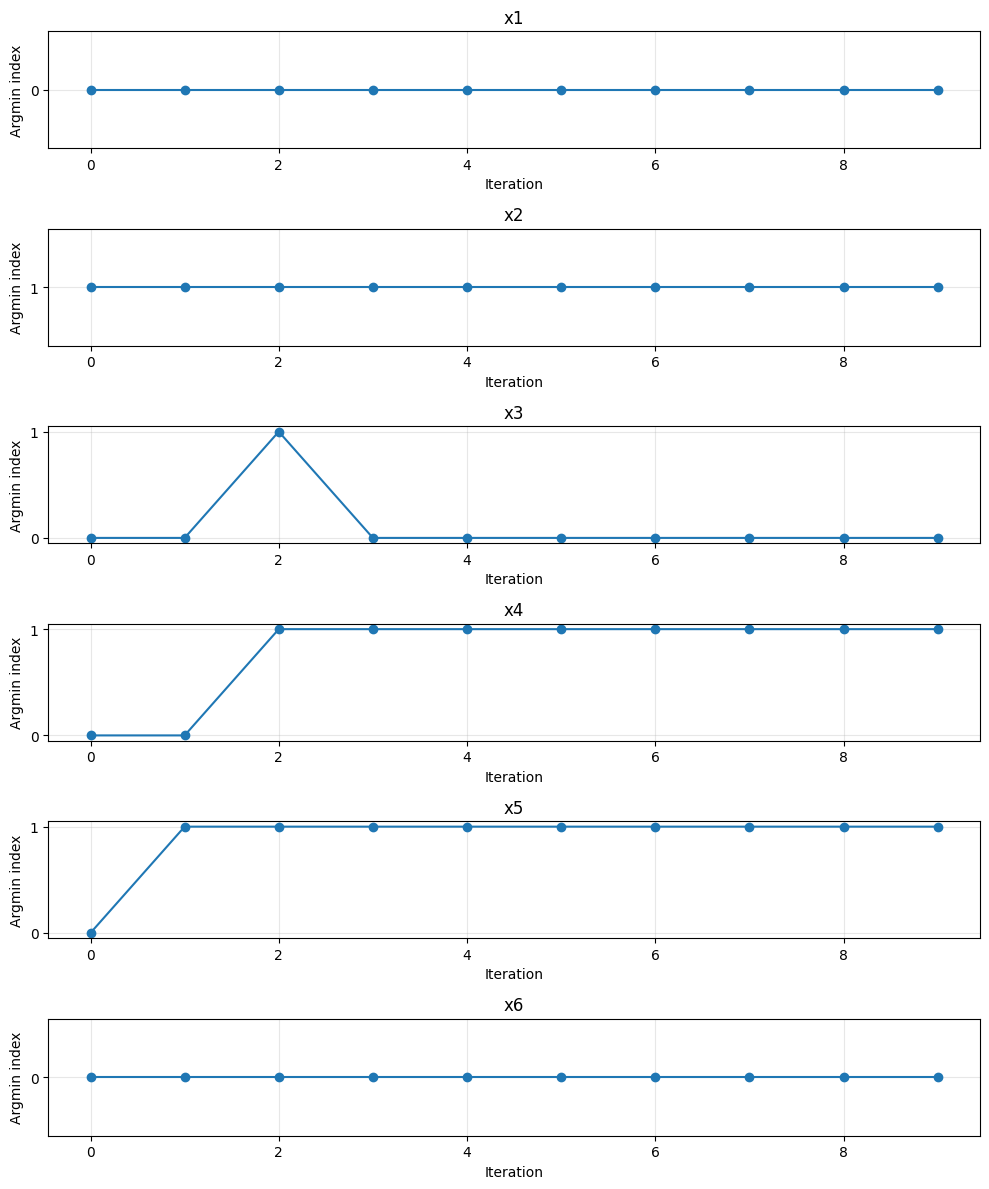

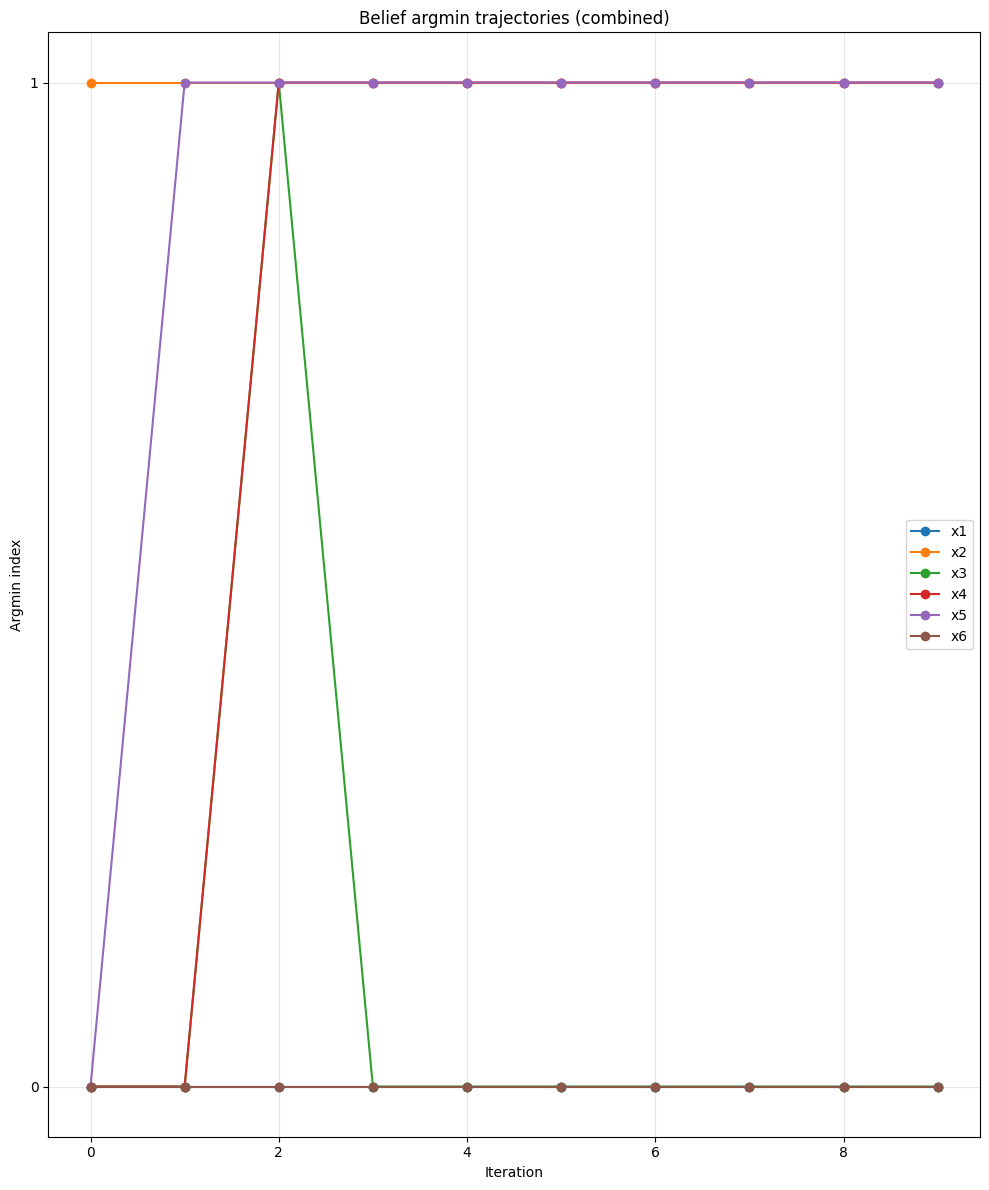

In [4]:
visualizer = SnapshotVisualizer(snapshots)  # type: ignore
print("Variables:", visualizer.variables())
series = visualizer.argmin_series()
print("Series tracked for", len(series), "variables")

visualizer.plot_argmin_per_variable(
    vars_filter=visualizer.variables()[:6],
    figsize=(10, 12),
)
plt.show()
